A very protracted and unsuccessful effort to code up Quinlan 1996. I'm not sure where the issue was; I was probably fundamentally misunderstanding a great deal about the paper. Couldn't get it to properly match any of the paper's results; theoretically got it all to *work*, though. 

Redid this using Sesana 2006 and got it to work quite beautifully, so this was abandoned and not used by any of my actual research.

In [1]:
from enterprise import constants as const
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from matplotlib import ticker    #comment back in if I want to make x-axis nHz instead of Hz
#from labellines import labelLine, labelLines    #comment back in if you want in-line labels

# a large number of setup functions to support the important ones

In [2]:
def getH0(q):
    """:param q: mass ratio, <=1"""
    qInverted = 1/q
    qInverteds = np.array([1, 4, 16, 64, 256])
    H0s = np.array([17.97, 20.54, 21.87, 22.78, 22.57])
    H0 = np.interp(qInverted, qInverteds, H0s) #might need to improve the interpolation function potentially
    print("H0 = " + str(H0))
    return H0

Values for $H_0$ linearly interpolated from Table 1 in Quinlan (1996).

In [3]:
def getwVbin(q):
    """:param q: mass ratio, <=1"""
    #returns w/Vbin, NOT w
    qInverted = 1/q
    qInverteds = np.array([1, 4, 16, 64, 256])
    wVbins = np.array([0.5675, 0.4263, 0.228, 0.1043, 0.0573])
    wVbin = np.interp(qInverted, qInverteds, wVbins) #might need to improve the interpolation function
    print("w/Vbin = " + str(wVbin))
    return wVbin

def getVbin(M, a):
    G = 6.67 * (10 ** -11)
    return np.sqrt(G * M / a)

def getw(q, M, a):
    """
    :param q: mass ratio, <=1
    :param M: total mass, UNITS
    :param a: current separation, UNITS
    """
    #returns w itself
    Vbin = getVbin(M, a)
    print("Vbin = " + str(Vbin))
    #FIX UNITS, including G, what are the units of G
    w = getwVbin(q) * Vbin
    print("w = " + str(w))
    return w

Values for $w/V_{bin}$ linearly interpolated from Table 1 in Quinlan (1996), and $w$ calculated from that using the definition $V_{bin} = \sqrt{\frac{GM_{tot}}{a}}$ for a circular binary.

In [4]:
def getH1(q, M, a, v):
    """
    :param q: mass ratio, <=1
    :param M: total mass, UNITS
    :param a: current separation, UNITS
    :param v: "initial stellar velocity," UNITS
    """
    H0 = getH0(q)
    w = getw(q, M, a)
    H1 = H0 / np.sqrt(1 + ((v/w) ** 4))
    print("H1 = " + str(H1))
    return H1

Using the expression $$H_1 = \frac{H_0}{\sqrt{1 + (v/w)^4}}$$ as in eq. 16 from Quinlan (1996).

Actually, I suspect I'm somehow misunderstanding how to implement this, because I don't see a way to incorporate eccentricity into this, and yet Fig. 1 plots based on eccentricity? Maybe that's just something about how $V_{bin}$ is defined? Or maybe it's buried in $w$, because I still don't really understand what $w$ is supposed to *represent.*

In [11]:
testQ = 1
testM = 2 * (10 ** 39) #10^8 solar masses
testA = 3 * (10 ** 16) #1 pc
testSigma = 2 * (10 ** 6) #2,000 km/s (unrealistic, but good for testing because it should give about v/Vbin = 1)
print("H = " + str(getH(testQ, testM, testA, testSigma)))
print("v/Vbin = " + str(testSigma / getVbin(testM, testA)))

H0 = 17.97
Vbin = 2108712.087191295
w/Vbin = 0.5675
w = 1196694.10948106
H1 = 2.129424998979587
Vbin = 2108712.087191295
w/Vbin = 0.5675
w = 1196694.10948106
H = 5.117236410776937
v/Vbin = 0.9484462161280186


If $v/V_{bin} \approx 1$ should give $H_1 \approx 9$, if I'm reading the chart correctly. Something's not right.

In [6]:
def getH(q, M, a, sigma):
    alpha = 1.16
    beta = 2.40
    return getH1(q, M, a, sigma * (3 ** (1/2))) * ( np.sqrt(2 / np.pi) + np.log(1 + (alpha * ( (sigma/getw(q, M, a) ) ** beta))))

Using the approximate eq. 18 from Quinlan (1996): $$\frac{H(\sigma)}{H_1(\sqrt{3}\sigma)} \simeq \sqrt{\frac{2}{\pi}} + \ln \left[1 + \alpha\left(\frac{\sigma}{w}\right)^{\beta}\right]$$ which is a numerical integration with $\alpha = 1.16$ and $\beta = 2.40$. 

I'm assuming here that $\sigma$ and $v$ are interchangeable, but I suspect that's not true because he defines a function $f(v, \sigma)$ in equation 7, so I believe they're different parameters--but then, he defines $H_1(v)$ but uses $H_1(\sqrt{3}\sigma)$ in the above equation, so who knows. $v$ is described as the "initial stellar velocity" and Quinlan models the experiments such that all stars start with this velocity at infinity. Velocity dispersion is such that the average/central velocity should be $0$ with a standard deviation of $\sigma$, right? Surely it's not that $v$ is the central velocity with a distribution of $\sigma$ *around* $v$?

Answer: $\sigma$ is the distribution, $v$ is a free variable, so $f(v, \sigma)$ is basically asking "what's the output when $v$ is our input, given a $\sigma$ distribution?" So actually I think making $v$ and $\sigma$ interchangeable in terms of inputs here is actually quite reasonable?

# The functions that were the actual point of this

In [7]:
def ssSeparationEvolution(q, totalMass, separation, density, dispersion): #variables missing for disk computation
    """
    Returns the rate of change of the orbital separation of a SMBH binary due to the affects of stellar scattering.
    
    :return: da/dt in . . . pc/s, probably?
    """
    #fix units
    H = getH(q, totalMass, separation, dispersion)
    return (separation ** 2) * G * density * H / dispersion

^ Calculates $\frac{da}{dt}$ using the expression $\frac{a^2G\rho}{\sigma}H$ from Sesana (2013) and Joseph J. Simon's UWM thesis, both of which cite Quinlan (1996), used above.

In [8]:
def ssFreqEvolution(q, mTot, separation):
    """
    :param a: mass ratio, < 1, decimal
    :param mTot: total mass, in solar masses
    :param accretionRate: mass accretion rate at outer edge of disk, in [unit]
    :param separation: current orbital separation, in pc
    disk variables
    
    :return: dw/dt in s^-2, using the expression dw/dt = -3(M^1/2)(a^-5/2)(da/dt) / 2
    #that's so ugly. I latexed it below (although I guess Jupyter can't render latex? :( Come on Jupyter! might still be clearer though)
    #that expression comes from just differentiating w = sqrt(M/a^3) using the chain rule; is it correct?
    """
    aDot = ssSeparationEvolution(q, mTot, accretionRate, separation) #da/dt
    return -3 * (mTot ** 1/2) * (separation ** -5/2) * aDot / 2

^ calculates $\frac{d\omega}{dt} = -\frac{3}{2}\sqrt{\frac{M}{a^5}}\frac{da}{dt}$ (from $\omega = \sqrt{\frac{M}{a^3}}$)

Now I have an expression for the frequency evolution due to gravitational radiation. THe plan was to have a graph that had df/dt on the left and f on the right and crossing lines for GW and SS, but I abandoned this before I could finish it. Kinda curious if this would have matched the Sesana stuff if I had tried it! (I don't think it would have, this didn't seem to be working properly--but it'd be interesting to check!)

In [9]:
def gwFreqEvolution(mass, freq): #mass in solar masses, freq in s^-1
    M = mass * 5 * (10 ** -6) # find mass expressed in seconds, rather than solar masses
    return (-96/5) * (M**(5/3)) * (freq**(11/3))

Now an attempt to graph it:

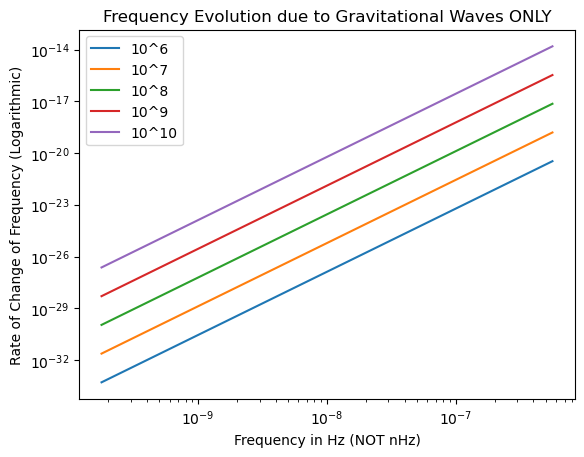

In [10]:
wSamples = []
wInit = (10 ** -0.75) * (10 ** -9) #in hertz
for w in range(8):
    wSamples.append(wInit)
    wInit = wInit * (10 ** 0.5)

masses = [0] * 5
for m in range(11 - 6):
    masses[m] = []
    for w in range(len(wSamples)):
        masses[m].append(-gwFreqEvolution(10 ** (m + 6), wSamples[w]))

fig, ax = plt.subplots()
for m in range(11 - 6):
    ax.plot(wSamples, masses[m], label='10^' + str(m + 6))
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("Frequency in Hz (NOT nHz)")
plt.ylabel("Rate of Change of Frequency (Logarithmic)")
plt.title("Frequency Evolution due to Gravitational Waves ONLY")
plt.legend()
#ax.set_xticks([1, 10, 100])
#ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())